In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import time

In [2]:
# Define functions
def preprocess_data(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    X = df.drop("label", axis=1)
    
    # Replace infinite values with NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Check if there are any NaN values after replacing infinite values
    print("Are there any NaN values in X after replacing infinite values?", np.any(np.isnan(X)))

    # Handle NaN values by filling with the mean of respective columns
    X.fillna(X.mean(), inplace=True)
    
    # Check again if there are any NaN values after filling with the mean
    print("Are there any NaN values in X after filling with the mean?", np.any(np.isnan(X)))

    y = df["label"]
    
    labels = pd.factorize(y)[1]  # This retrieves the original labels
    label_counts = y.value_counts()

    ddos_count = label_counts[labels[0]]  # Assuming DDoS label is encoded as 0
    benign_count = label_counts[labels[1]]  # Assuming Benign label is encoded as 1

    print(f"Number of DDoS values: {ddos_count}")
    print(f"Number of Benign values: {benign_count}")
    y_encoded = pd.factorize(y)[0]
    return X, y_encoded

def select_best_features(X, y_encoded, k_features):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    selector = SelectKBest(score_func=chi2, k=k_features)
    X_selected = selector.fit_transform(X_scaled, y_encoded)
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X.columns[selected_feature_indices]
    X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)
    return X_selected_df

def evaluate_and_get_results(model, model_name, X_test, y_test):
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    
    print(f"{model_name} Results:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    
    return accuracy, precision, recall, f1


def evaluate_model_with_visualizations(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    unique_labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    report = classification_report(y_test, y_pred, labels=unique_labels)
    print("Classification Report:\n", report)

    print("Time taken for prediction:", elapsed_time, "seconds")
    
def visualize_confusion_matrices(models_anomaly, X_test, y_test):
    plt.figure(figsize=(15, 10))
    
    num_rows = len(models_anomaly) // 3 + (len(models_anomaly) % 3 > 0)  # Calculate the number of rows needed
    
    for idx, (model_name, model) in enumerate(models_anomaly.items(), start=1):
        plt.subplot(num_rows, 3, idx)  # Dynamic number of rows and 3 columns of subplots
        evaluate_model_with_visualizations(model, X_test, y_test)
        plt.title(model_name)

    plt.tight_layout()
    plt.show()
    
def evaluate_anomaly_detection(algorithm, algorithm_name, X_test, y_test):
    plt.figure(figsize=(10, 5))
    
    if algorithm_name == "Isolation Forest":
        # Evaluate Isolation Forest and get anomaly scores
        anomaly_scores = algorithm.decision_function(X_test)
        
        # Plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{algorithm_name} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.title(f"{algorithm_name} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        
    elif algorithm_name == "Autoencoder":
        # Calculate reconstruction errors
        X_test_encoded = algorithm.predict(X_test)
        reconstruction_errors = np.mean(np.square(X_test - X_test_encoded), axis=1)
        
        # Plot Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)
        auc_score = auc(recall, precision)
        plt.plot(recall, precision, label=f"{algorithm_name} (AUC = {auc_score:.2f})")
        plt.title(f"{algorithm_name} Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
    
    plt.show()
    
def perform_cross_validation(model, X, y, cv=5, scoring='accuracy'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores

In [3]:
def train_random_forest(X, y_encoded):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y_encoded)
    return rf_model

def train_naive_bayes(X, y_encoded):
    nb_model = GaussianNB()
    nb_model.fit(X, y_encoded)
    return nb_model

def train_logistic_regression(X, y_encoded):
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X, y_encoded)
    return lr_model

def train_isolation_forest(X):
    iso_forest_model = IsolationForest(contamination=0.05, random_state=42)
    iso_forest_model.fit(X)
    return iso_forest_model

def train_extra_trees(X, y_encoded):
    et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    et_model.fit(X, y_encoded)
    return et_model

def train_mlp_with_tensorflow(X, y_encoded):
    # Define the architecture of the custom MLP model using TensorFlow
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the TensorFlow model
    model.fit(X, y_encoded, epochs=50, batch_size=64, validation_split=0.1)
    
    return model

def train_autoencoder_with_tensorflow(X):
    # Define the Autoencoder architecture using TensorFlow
    input_dim = X.shape[1]
    encoding_dim = 64
    
    autoencoder_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(encoding_dim, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation='sigmoid')
    ])
    
    # Compile the Autoencoder model
    autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the Autoencoder
    autoencoder_model.fit(X, X, epochs=50, batch_size=64, shuffle=True, validation_split=0.1)
    
    return autoencoder_model

In [4]:
# Read the dataset
csv_file_path = r'D:\ISS\Дипломна работа\CICIDS2017\archive\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
df = pd.read_csv(csv_file_path)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

In [5]:
df.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                       6   
4                             0                       6   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                       6                      6.0                     0.0   
1                       6                      6.0                     0.0   
2                       6                      6.0                     0.0   
3                       6                      6.0                     0.0   
4                       6                      6.0                     0.0   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...                     20          0.0          0.0            0   
1  ...                     20          0.0          0.0            0   
2  ...                     20          0.0          0.0            0   
3  ...                     20          0.0          0.0            0   
4  ...                     20          0.0          0.0            0   

    Active Min  Idle Mean   Idle Std   Idle Max   Idle Min   Label  
0            0        0.0        0.0          0          0  BENIGN  
1            0        0.0        0.0          0          0  BENIGN  
2            0        0.0        0.0          0          0  BENIGN  
3            0        0.0        0.0          0          0  BENIGN  
4            0        0.0        0.0          0          0  BENIGN  

[5 rows x 79 columns]

In [6]:
# Preprocessing
X, y_encoded = preprocess_data(df)

Are there any NaN values in X after replacing infinite values? True
Are there any NaN values in X after filling with the mean? False
Number of DDoS values: 97718
Number of Benign values: 128027


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             225745 non-null  int64  
 1   flow_duration                225745 non-null  int64  
 2   total_fwd_packets            225745 non-null  int64  
 3   total_backward_packets       225745 non-null  int64  
 4   total_length_of_fwd_packets  225745 non-null  int64  
 5   total_length_of_bwd_packets  225745 non-null  int64  
 6   fwd_packet_length_max        225745 non-null  int64  
 7   fwd_packet_length_min        225745 non-null  int64  
 8   fwd_packet_length_mean       225745 non-null  float64
 9   fwd_packet_length_std        225745 non-null  float64
 10  bwd_packet_length_max        225745 non-null  int64  
 11  bwd_packet_length_min        225745 non-null  int64  
 12  bwd_packet_length_mean       225745 non-null  float64
 13 

In [8]:
X.head()

destination_port  flow_duration  total_fwd_packets  total_backward_packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   total_length_of_fwd_packets  total_length_of_bwd_packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   fwd_packet_length_max  fwd_packet_length_min  fwd_packet_length_mean  \
0                      6                      6                     6.0   
1                      6                      6                     6.0   
2                      6                      6                     6.0   
3                      6                      6                     6.0   
4                      6                      6                     6.0   

   fwd_packet_length_std  ...  act_data_pkt_fwd  min_seg_size_forward  \
0                    0.0  ...                 1                    20   
1                    0.0  ...                 0                    20   
2                    0.0  ...                 0                    20   
3                    0.0  ...                 0                    20   
4                    0.0  ...                 1                    20   

   active_mean  active_std  active_max  active_min  idle_mean  idle_std  \
0          0.0         0.0           0           0        0.0       0.0   
1          0.0         0.0           0           0        0.0       0.0   
2          0.0         0.0           0           0        0.0       0.0   
3          0.0         0.0           0           0        0.0       0.0   
4          0.0         0.0           0           0        0.0       0.0   

   idle_max  idle_min  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

[5 rows x 78 columns]

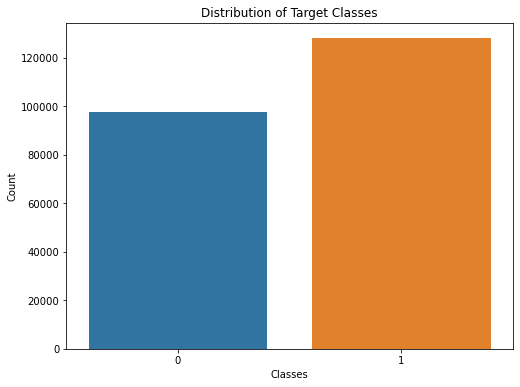

In [9]:
# Visualize the distribution of y_encoded
plt.figure(figsize=(8, 6))
sns.countplot(x=y_encoded)
plt.title("Distribution of Target Classes")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

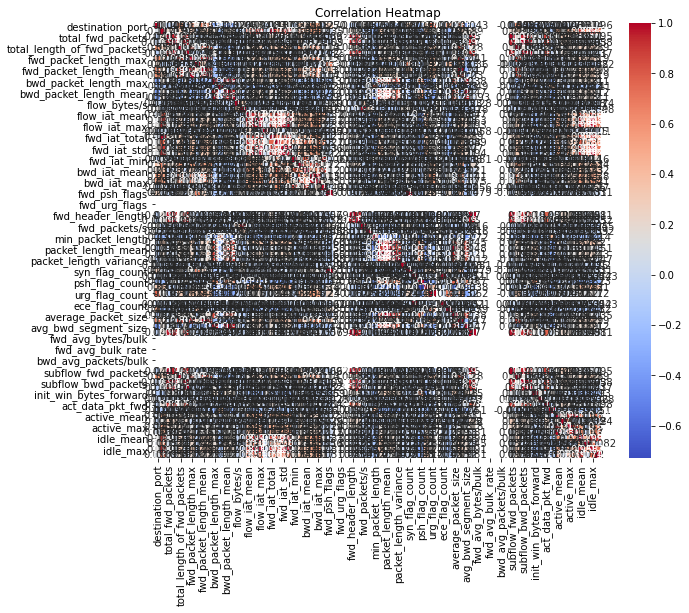

In [10]:
# Visualize correlations among features
corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# Feature Selection
k_features = 20
X_selected_df = select_best_features(X, y_encoded, k_features)

In [12]:
# Get the list of selected feature names
selected_feature_names = X_selected_df.columns.tolist()

# Print the selected feature names
print("Selected Features:", selected_feature_names)

Selected Features: ['destination_port', 'fwd_packet_length_max', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'bwd_iat_total', 'bwd_iat_max', 'fwd_psh_flags', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'syn_flag_count', 'psh_flag_count', 'urg_flag_count', 'average_packet_size', 'avg_fwd_segment_size', 'avg_bwd_segment_size']


#### Data Visualization After Feature Selection 

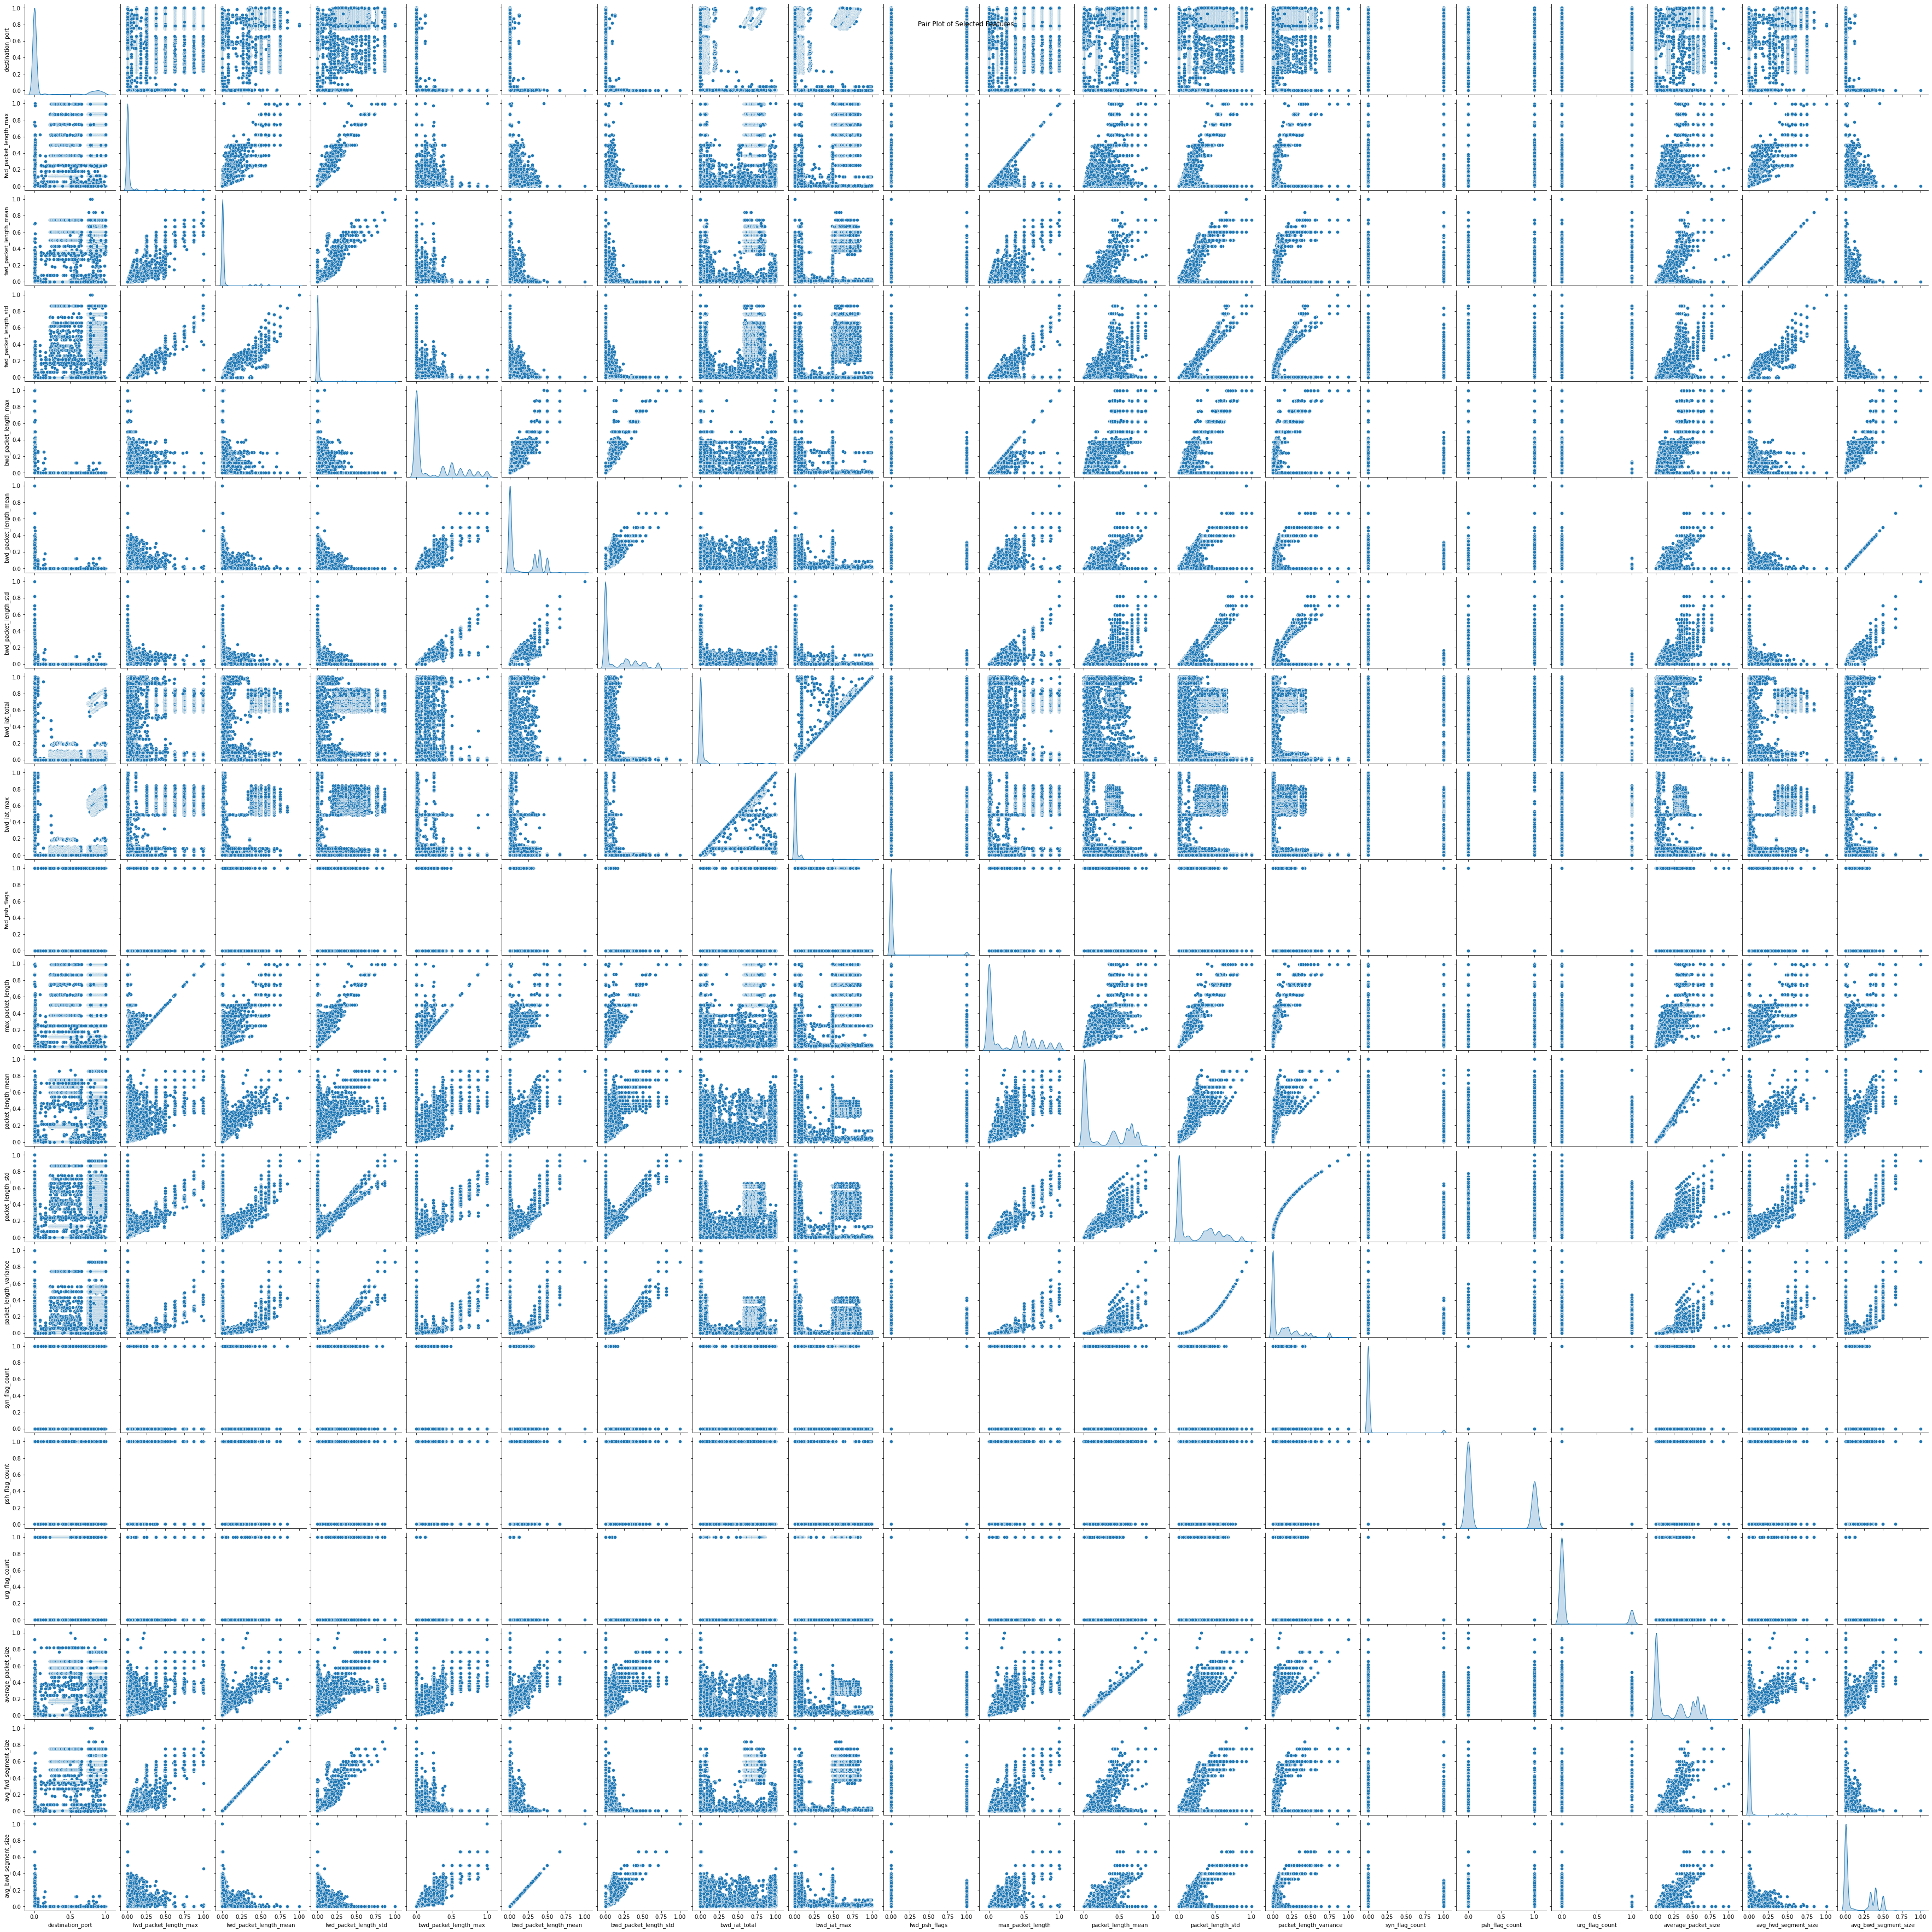

In [13]:
# Visualize the selected features
sns.pairplot(data=X_selected_df, diag_kind="kde")
plt.suptitle("Pair Plot of Selected Features")
plt.show()

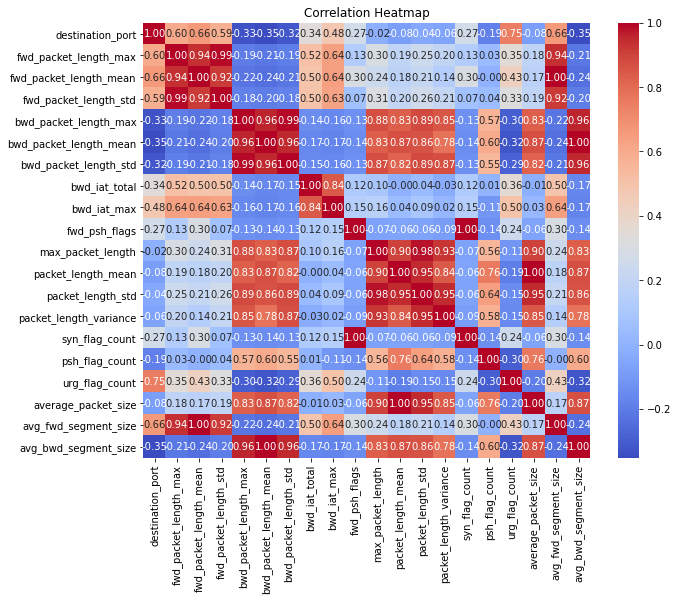

In [14]:
correlation_matrix = X_selected_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y_encoded, test_size=0.2, random_state=42)

In [16]:
# Resample training data
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


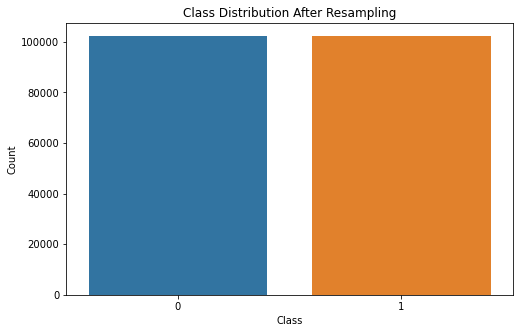

In [17]:
# Visualize class distribution after resampling
plt.figure(figsize=(8, 5))
sns.countplot(y_train_resampled)
plt.title("Class Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Random Forest Results on Test Set:


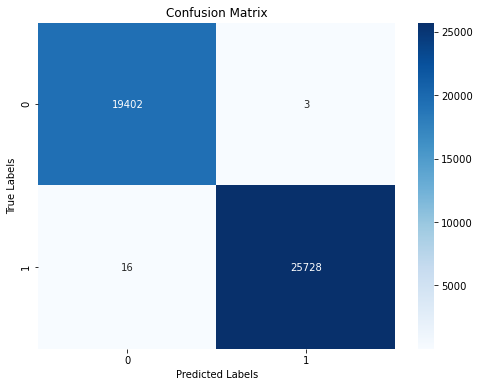

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19405
           1       1.00      1.00      1.00     25744

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149

Time taken for prediction: 0.32965803146362305 seconds


In [18]:
# Train and evaluate Random Forest model
rf_model = train_random_forest(X_train_resampled, y_train_resampled)
print("Random Forest Results on Test Set:")
evaluate_model_with_visualizations(rf_model, X_test, y_test)

In [19]:
# Train and evaluate Random Forest model
rf_model = train_random_forest(X_train_resampled, y_train_resampled)
y_pred = rf_model.predict(X_test)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix in text table form
print("Confusion Matrix:")
print("------------------------------")
print(f"True Positive: {conf_matrix[1][1]} | False Negative: {conf_matrix[1][0]}")
print(f"False Positive: {conf_matrix[0][1]} | True Negative: {conf_matrix[0][0]}")
print("------------------------------")

Confusion Matrix:
------------------------------
True Positive: 25728 | False Negative: 16
False Positive: 3 | True Negative: 19402
------------------------------


In [20]:
# Perform cross-validation for Random Forest
rf_scores = perform_cross_validation(rf_model, X_train_resampled, y_train_resampled)
print("Random Forest Cross-Validation Scores:")
print(rf_scores)
print("Average Score:", np.mean(rf_scores))
print()

Random Forest Cross-Validation Scores:
[0.99973114 0.9995356  0.99963337 0.99958448 0.99965781]
Average Score: 0.9996284812595342



Naive Bayes Results on Test Set:


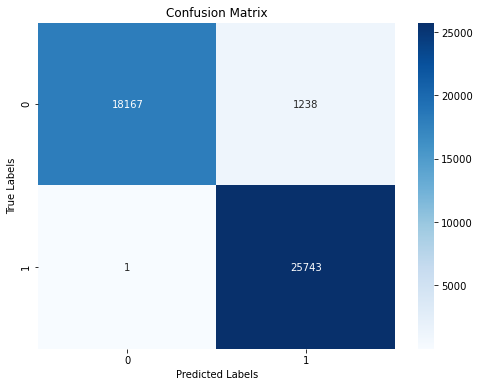

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     19405
           1       0.95      1.00      0.98     25744

    accuracy                           0.97     45149
   macro avg       0.98      0.97      0.97     45149
weighted avg       0.97      0.97      0.97     45149

Time taken for prediction: 0.042993783950805664 seconds


In [21]:
# Train and evaluate Naive Bayes model
nb_model = train_naive_bayes(X_train_resampled, y_train_resampled)
print("Naive Bayes Results on Test Set:")
evaluate_model_with_visualizations(nb_model, X_test, y_test)

In [22]:
# Perform cross-validation for Random Forest
nb_scores = perform_cross_validation(nb_model, X_train_resampled, y_train_resampled)
print("Naive Bayes Cross-Validation Scores:")
print(nb_scores)
print("Average Score:", np.mean(nb_scores))
print()

Naive Bayes Cross-Validation Scores:
[0.96881263 0.96829858 0.96961846 0.96903185 0.96886075]
Average Score: 0.9689244552458565



Logistic Regression Results on Test Set:


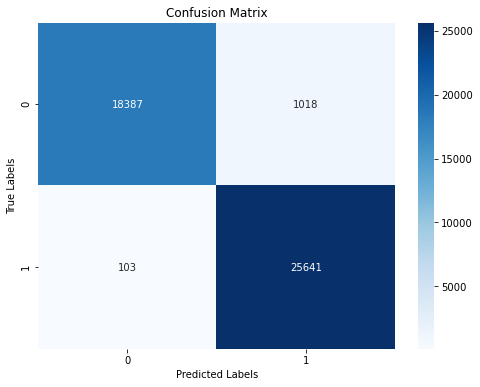

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     19405
           1       0.96      1.00      0.98     25744

    accuracy                           0.98     45149
   macro avg       0.98      0.97      0.97     45149
weighted avg       0.98      0.98      0.98     45149

Time taken for prediction: 0.0050754547119140625 seconds


In [23]:
# Train and evaluate Logistic Regression model
lr_model = train_logistic_regression(X_train_resampled, y_train_resampled)
print("Logistic Regression Results on Test Set:")
evaluate_model_with_visualizations(lr_model, X_test, y_test)

In [24]:
# Perform cross-validation for Logistic Regression
lr_scores = perform_cross_validation(lr_model, X_train_resampled, y_train_resampled)
print("Logistic Regression Cross-Validation Scores:")
print(lr_scores)
print("Average Score:", np.mean(lr_scores))
print()

Logistic Regression Cross-Validation Scores:
[0.97223444 0.97084056 0.97228265 0.97238042 0.97223376]
Average Score: 0.9719943673920615



Isolation Forest Results on Test Set:


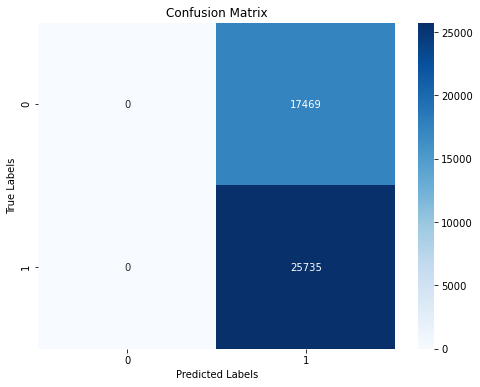

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     19405
           1       0.60      1.00      0.75     25744

   micro avg       0.60      0.57      0.58     45149
   macro avg       0.30      0.50      0.37     45149
weighted avg       0.34      0.57      0.43     45149

Time taken for prediction: 0.4034128189086914 seconds


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Train and evaluate Isolation Forest model
iso_forest_model = train_isolation_forest(X_train_resampled)
print("Isolation Forest Results on Test Set:")
evaluate_model_with_visualizations(iso_forest_model, X_test, y_test)

In [26]:
# Train and evaluate Isolation Forest model
iso_forest_model = train_isolation_forest(X_train_resampled)
y_pred_iso = iso_forest_model.predict(X_test)

# Get the confusion matrix
conf_matrix_iso = confusion_matrix(y_test, y_pred_iso)

# Print confusion matrix in text table form
print("Isolation Forest Confusion Matrix:")
print("------------------------------")
print(f"True Positive: {conf_matrix_iso[1][1]} | False Negative: {conf_matrix_iso[1][0]}")
print(f"False Positive: {conf_matrix_iso[0][1]} | True Negative: {conf_matrix_iso[0][0]}")
print("------------------------------")


Isolation Forest Confusion Matrix:
------------------------------
True Positive: 0 | False Negative: 1936
False Positive: 0 | True Negative: 0
------------------------------


Extra Trees Results on Test Set:


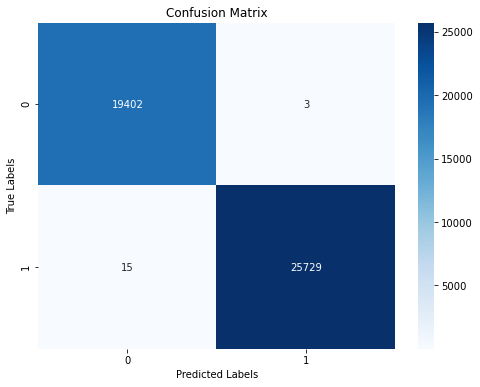

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19405
           1       1.00      1.00      1.00     25744

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149

Time taken for prediction: 0.4392354488372803 seconds


In [27]:
# Train and evaluate Extra Trees model
et_model = train_extra_trees(X_train_resampled, y_train_resampled)
print("Extra Trees Results on Test Set:")
evaluate_model_with_visualizations(et_model, X_test, y_test)

In [28]:
# Perform cross-validation for Extra Trees
et_scores = perform_cross_validation(et_model, X_train_resampled, y_train_resampled)
print("Extra Trees Cross-Validation Scores:")
print(et_scores)
print("Average Score:", np.mean(et_scores))
print()

Extra Trees Cross-Validation Scores:
[0.99968226 0.9995356  0.99963337 0.99956004 0.99965781]
Average Score: 0.999613816233176



In [32]:
# Train and evaluate the TensorFlow-based MLP regression model
tensorflow_mlp_model = train_mlp_with_tensorflow(X_train_resampled, y_train_resampled)

# Predict using the regression model
y_pred = tensorflow_mlp_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

print("MLP Regression Results on Test Set:")
print("Mean Squared Error:", mse)

Epoch 1/50
2877/2877 [==============================] - 8s 3ms/step - loss: 0.1141 - accuracy: 0.9569 - val_loss: 0.0790 - val_accuracy: 0.9994
Epoch 2/50
2877/2877 [==============================] - 7s 2ms/step - loss: 0.0617 - accuracy: 0.9813 - val_loss: 0.0414 - val_accuracy: 0.9999
Epoch 3/50
2877/2877 [==============================] - 7s 2ms/step - loss: 0.0497 - accuracy: 0.9855 - val_loss: 0.0208 - val_accuracy: 0.9999
Epoch 4/50
2877/2877 [==============================] - 7s 2ms/step - loss: 0.0388 - accuracy: 0.9901 - val_loss: 0.0235 - val_accuracy: 0.9999
Epoch 5/50
2877/2877 [==============================] - 7s 2ms/step - loss: 0.0346 - accuracy: 0.9924 - val_loss: 0.0143 - val_accuracy: 0.9999
Epoch 6/50
2877/2877 [==============================] - 7s 2ms/step - loss: 0.0343 - accuracy: 0.9924 - val_loss: 0.0238 - val_accuracy: 0.9999
Epoch 7/50
2877/2877 [==============================] - 7s 2ms/step - loss: 0.0343 - accuracy: 0.9924 - val_loss: 0.0125 - val_accuracy:

In [36]:
# Create an instance of the MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(mlp_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean CV Score:", cross_val_scores.mean())

Cross-Validation Scores: [0.99877792 0.99931562 0.99921785 0.99926674 0.99924229]
Mean CV Score: 0.9991640858508326


In [39]:
# Train and evaluate the TensorFlow-based Autoencoder model
tensorflow_autoencoder_model = train_autoencoder_with_tensorflow(X_train_resampled)

Epoch 1/50
2877/2877 [==============================] - 8s 2ms/step - loss: 0.0079 - val_loss: 1.2721e-04
Epoch 2/50
2877/2877 [==============================] - 7s 2ms/step - loss: 1.5212e-04 - val_loss: 6.2470e-05
Epoch 3/50
2877/2877 [==============================] - 7s 2ms/step - loss: 8.6041e-05 - val_loss: 4.0252e-05
Epoch 4/50
2877/2877 [==============================] - 7s 2ms/step - loss: 5.5389e-05 - val_loss: 2.6020e-05
Epoch 5/50
2877/2877 [==============================] - 7s 2ms/step - loss: 3.8794e-05 - val_loss: 1.8946e-05
Epoch 6/50
2877/2877 [==============================] - 7s 2ms/step - loss: 2.9803e-05 - val_loss: 1.5031e-05
Epoch 7/50
2877/2877 [==============================] - 7s 2ms/step - loss: 2.4485e-05 - val_loss: 1.0725e-05
Epoch 8/50
2877/2877 [==============================] - 7s 3ms/step - loss: 2.1336e-05 - val_loss: 9.5799e-06
Epoch 9/50
2877/2877 [==============================] - 7s 2ms/step - loss: 1.9096e-05 - val_loss: 8.3701e-06
Epoch 10/50
28

1411/1411 [==============================] - 3s 2ms/step


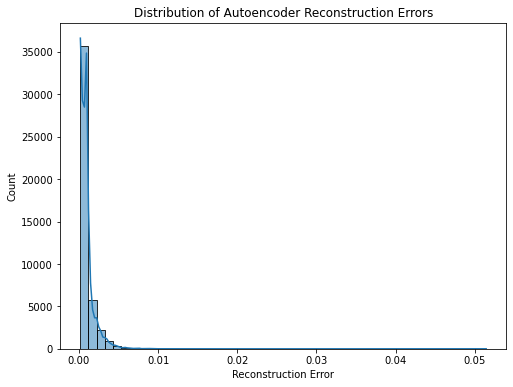

In [40]:
# Reconstruct test data using the trained Autoencoder
reconstructed_data = tensorflow_autoencoder_model.predict(X_test)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.abs(X_test - reconstructed_data), axis=1)

# Visualize the distribution of reconstruction errors
plt.figure(figsize=(8, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.title("Distribution of Autoencoder Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()

In [41]:
# Encode and decode the test set using the trained autoencoder
X_test_encoded = tensorflow_autoencoder_model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_encoded), axis=1)

# Calculate statistics on reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)
max_error = np.max(reconstruction_errors)

print("Autoencoder Results on Test Set:")
print("Mean Reconstruction Error:", mean_error)
print("Standard Deviation of Reconstruction Error:", std_error)
print("Maximum Reconstruction Error:", max_error)

1411/1411 [==============================] - 4s 2ms/step
Autoencoder Results on Test Set:
Mean Reconstruction Error: 5.363584110799001e-06
Standard Deviation of Reconstruction Error: 4.262932230244641e-05
Maximum Reconstruction Error: 0.007747216991058831


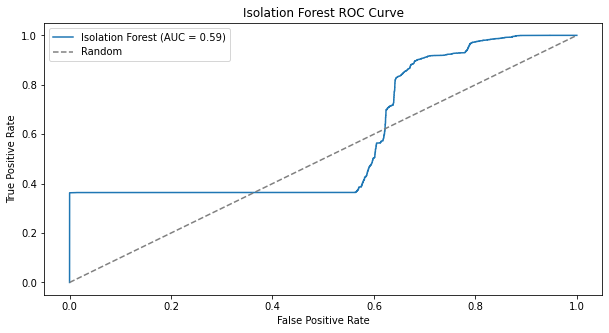

1411/1411 [==============================] - 3s 2ms/step


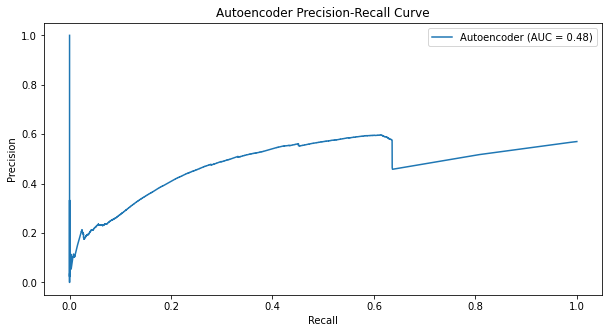

In [42]:
# Evaluate Isolation Forest
evaluate_anomaly_detection(iso_forest_model, "Isolation Forest", X_test, y_test)

# Evaluate Autoencoder
evaluate_anomaly_detection(tensorflow_autoencoder_model, "Autoencoder", X_test, y_test)

Random Forest Results:
Accuracy: 0.9995791711887306
Precision: 0.9995793748705244
Recall: 0.9995791711887306
F1-score: 0.999579188506524
Naive Bayes Results:
Accuracy: 0.9725575317282775
Precision: 0.9738131651927967
Recall: 0.9725575317282775
F1-score: 0.9724277120957495
Logistic Regression Results:
Accuracy: 0.9751711001351082
Precision: 0.9758320913153452
Recall: 0.9751711001351082
F1-score: 0.9750881116072951
Extra Trees Results:
Accuracy: 0.9996013200735343
Precision: 0.9996014944116348
Recall: 0.9996013200735343
F1-score: 0.9996013352203296


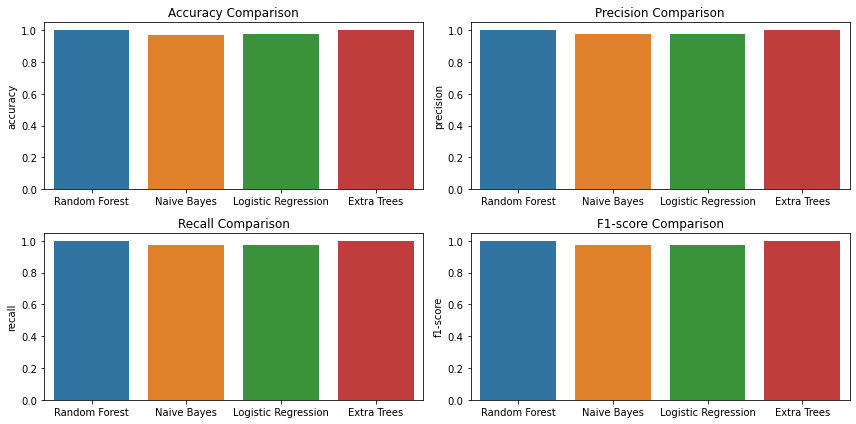

In [44]:
# Create a dictionary to store the results of each model
results = {}

models = {
    "Random Forest": rf_model,
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Extra Trees": et_model,
}

for model_name, model in models.items():
    # Evaluate the model
    accuracy, precision, recall, f1 = evaluate_and_get_results(model, model_name, X_test, y_test)
    
    # Store the results in the dictionary
    results[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).transpose()

# Visualize the results using bar plots
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df["accuracy"])
plt.title("Accuracy Comparison")

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df["precision"])
plt.title("Precision Comparison")

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y=results_df["recall"])
plt.title("Recall Comparison")

# F1-score
plt.subplot(2, 2, 4)
sns.barplot(x=results_df.index, y=results_df["f1-score"])
plt.title("F1-score Comparison")

plt.tight_layout()
plt.show()

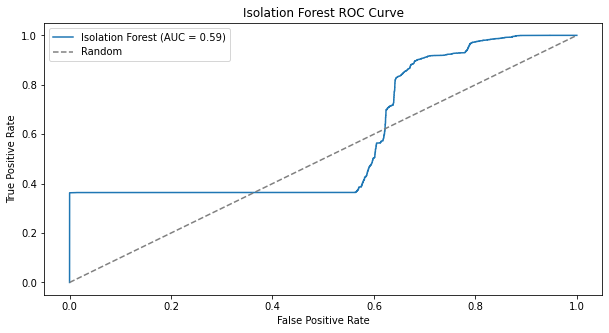

1411/1411 [==============================] - 3s 2ms/step


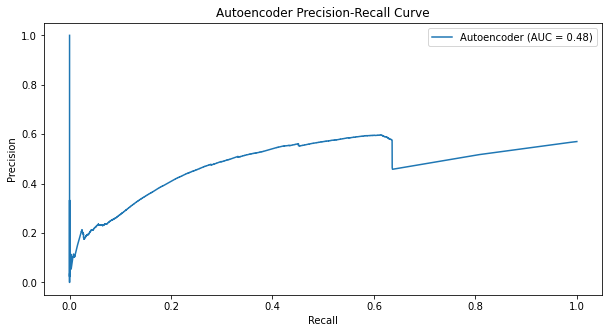

Random Forest Results:
Accuracy: 0.9995791711887306
Precision: 0.9995793748705244
Recall: 0.9995791711887306
F1-score: 0.999579188506524
Naive Bayes Results:
Accuracy: 0.9725575317282775
Precision: 0.9738131651927967
Recall: 0.9725575317282775
F1-score: 0.9724277120957495
Logistic Regression Results:
Accuracy: 0.9751711001351082
Precision: 0.9758320913153452
Recall: 0.9751711001351082
F1-score: 0.9750881116072951
Extra Trees Results:
Accuracy: 0.9996013200735343
Precision: 0.9996014944116348
Recall: 0.9996013200735343
F1-score: 0.9996013352203296


<Figure size 720x360 with 0 Axes>

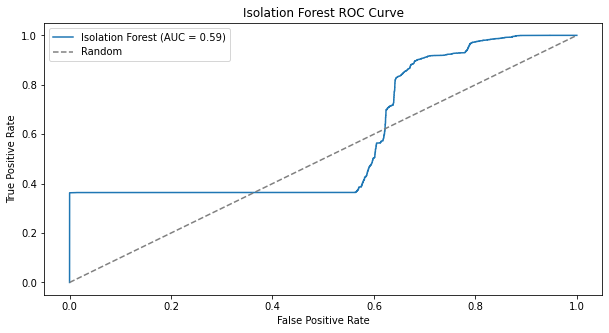

1411/1411 [==============================] - 3s 2ms/step


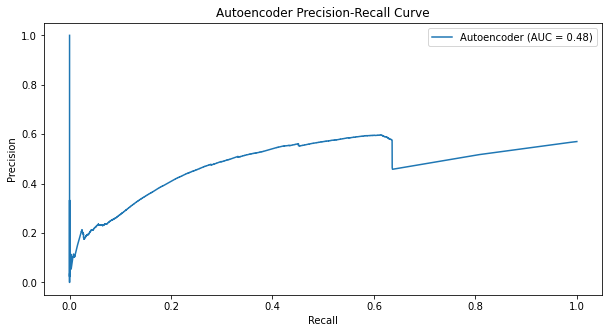

<Figure size 720x360 with 0 Axes>

In [48]:
# Add Isolation Forest, Autoencoder, and other classification models to the models dictionary
models_anomaly = {
    "Isolation Forest": iso_forest_model,
    "Autoencoder": tensorflow_autoencoder_model,
    "Random Forest": rf_model,
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Extra Trees": et_model,
    "MLP": mlp_model
}

# Create a dictionary to store the results of each model
results_anomaly = {}

for model_name, model in models_anomaly.items():
    if model_name in ["Isolation Forest", "Autoencoder", "MLP"]:
        # Evaluate anomaly detection models
        # Modify this part based on the evaluation metrics you choose
        evaluate_anomaly_detection(model, model_name, X_test, y_test)
    else:
        # Evaluate classification models
        accuracy, precision, recall, f1 = evaluate_and_get_results(model, model_name, X_test, y_test)
        results_anomaly[model_name] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1-score": f1
        }

# Create a DataFrame from the results dictionary
results_df_anomaly = pd.DataFrame(results_anomaly).transpose()

# Visualize the results for anomaly detection using ROC and Precision-Recall curves
for model_name in ["Isolation Forest", "Autoencoder", "MLP"]:
    evaluate_anomaly_detection(models_anomaly[model_name], model_name, X_test, y_test)

In [49]:
# Identify anomalies using the trained Isolation Forest model
anomalies = iso_forest_model.predict(X_test) == -1  # Anomalies are labeled as -1 by Isolation Forest

# Create a new dataset containing only the anomalies
anomalies_dataset = X_test[anomalies]

Random Forest Results on Anomalies Dataset:


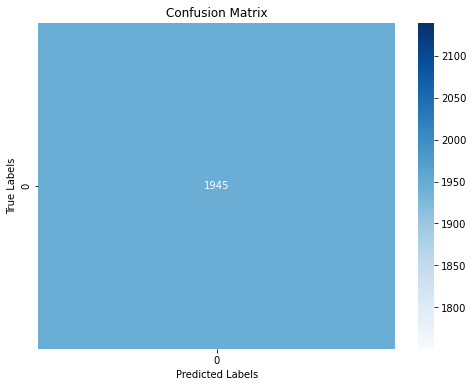

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1945

    accuracy                           1.00      1945
   macro avg       1.00      1.00      1.00      1945
weighted avg       1.00      1.00      1.00      1945

Time taken for prediction: 0.0 seconds
Naive Bayes Results on Anomalies Dataset:


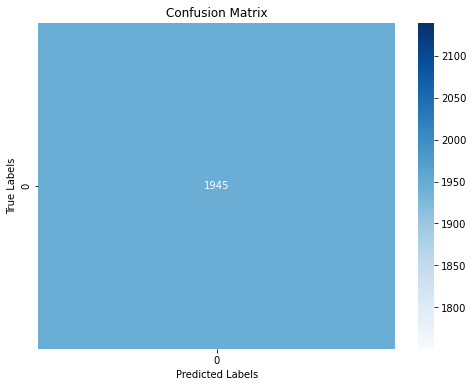

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1945

    accuracy                           1.00      1945
   macro avg       1.00      1.00      1.00      1945
weighted avg       1.00      1.00      1.00      1945

Time taken for prediction: 0.0033464431762695312 seconds


In [50]:
# Train and evaluate Random Forest model using anomalies_dataset
rf_model_anomalies = train_random_forest(anomalies_dataset, np.ones(anomalies_dataset.shape[0], dtype=int))
print("Random Forest Results on Anomalies Dataset:")
evaluate_model_with_visualizations(rf_model_anomalies, anomalies_dataset, np.ones(anomalies_dataset.shape[0], dtype=int))

# Train and evaluate Naive Bayes model using anomalies_dataset
nb_model_anomalies = train_naive_bayes(anomalies_dataset, np.ones(anomalies_dataset.shape[0], dtype=int))
print("Naive Bayes Results on Anomalies Dataset:")
evaluate_model_with_visualizations(nb_model_anomalies, anomalies_dataset, np.ones(anomalies_dataset.shape[0], dtype=int))